# 01. Quality Control and Doublet Filtering (by Scrublet)

It is recommended to start this process by downloading the {Cellbender filtered}.h5 files from GSE271257 (Chip VSGO and Chip HCO) and GSE264303 (i-VSNs and VSGOs).

This is the representative procedure of VSGO E3 snRNA day32 file(GSM8215758 from GSE264303). 

Follow this process for each of the 14 samples if you want to replicate it.

I have separately attached the file iVSN_iVSGO_singlet.csv, which contains the results of this step for the samples corresponding to i-VSN and VSGO.

You can skip this step and proceed to the integration task using that file

If you have any questions, please contact hwee38@snu.ac.kr


In [1]:
import scanpy as sc
import pandas as pd
import h5py
import anndata
import tables
import numpy as np
import scipy.sparse as sp
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns
import scrublet as scr
from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=60, facecolor='white')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# scRNA
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [4]:
import pkg_resources
scrublet_version = pkg_resources.get_distribution("scrublet").version
print(scrublet_version)

0.2.3


In [5]:
def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]

    return adata


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

In [6]:
adata = anndata_from_h5(file='cellbender_VSN_E3_spheroid_fresh_filtered.h5')
adata.var_names_make_unique()
adata

Assuming we are loading a "filtered" file that contains only cells.


AnnData object with n_obs × n_vars = 5779 × 38606
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [7]:
##add column
adata.obs['file']='VSN_E3_spheroid_fresh_day32'

ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
#ribo_genes
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 1)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

filtered out 4 cells that have less than 200 genes expressed
filtered out 8456 genes that are detected in less than 1 cells


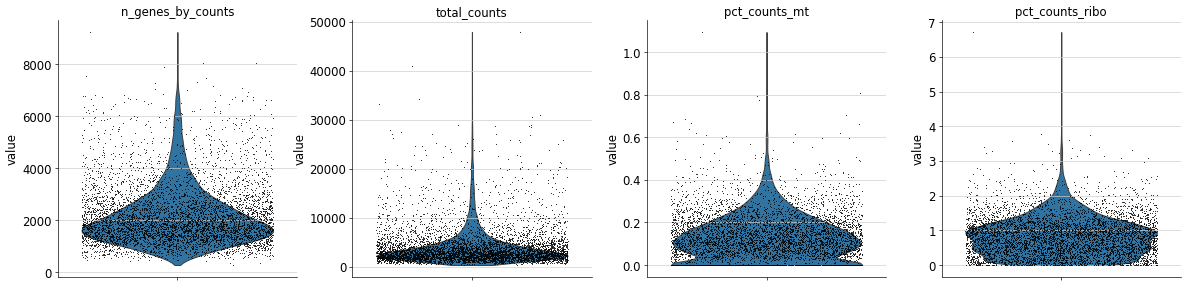

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [9]:
##Change column name
#adata.obs.rename(columns={"n_genes_by_counts": "n_genes"}, inplace=True)
#adata.obs.rename(columns={"total_counts": "n_counts"}, inplace=True)
#adata.obs.rename(columns={"pct_counts_mt": "mt_frac"}, inplace=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['DPP10', 'ROBO1', 'MALAT1', 'HTR2C']
    finished (0:00:00)
computing PCA
    with n_comps=20
    finished (0:00:17)


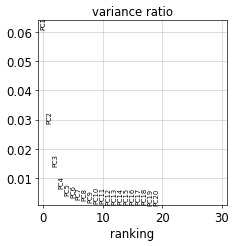

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [10]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=20,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=8, metric='correlation')
sc.tl.umap(adata_pp)

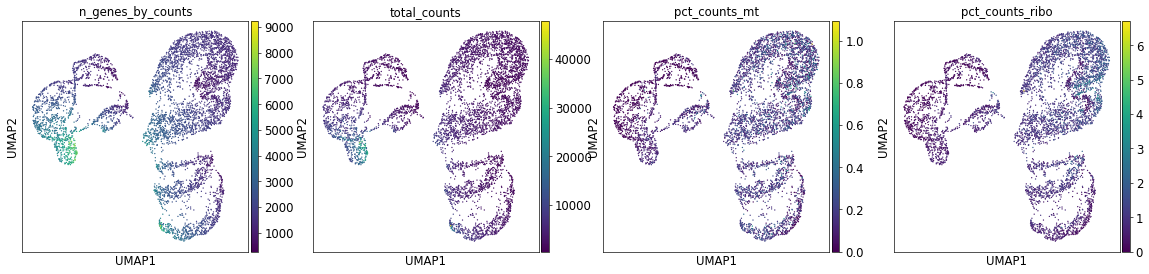

In [11]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_pp, color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],size=10)

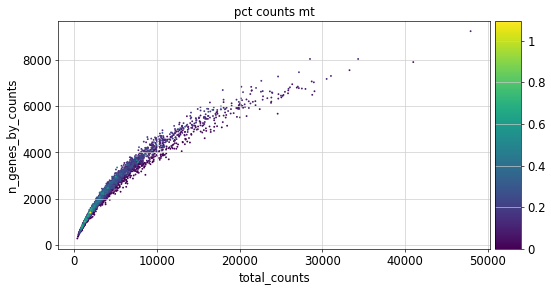

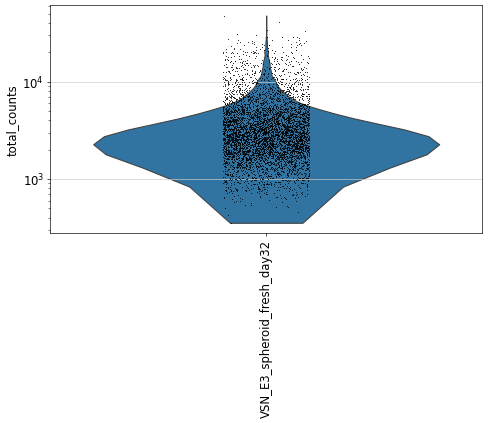

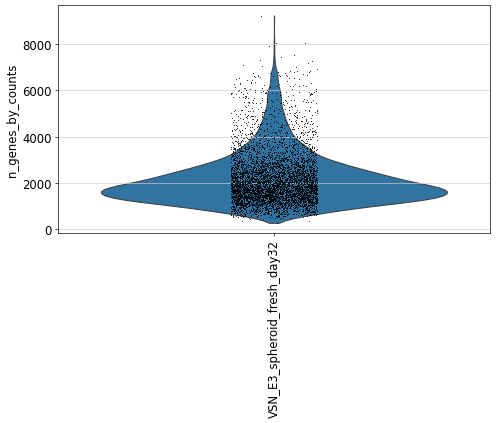

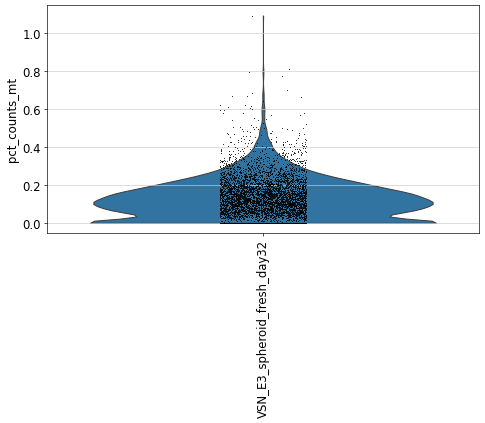

In [12]:
#Data quality summary plots
rcParams['figure.figsize']=(8,5)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', size=20)
sc.pl.violin(adata, ['total_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes_by_counts'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['pct_counts_mt'],  groupby='file', size=1, log=False,rotation=90)

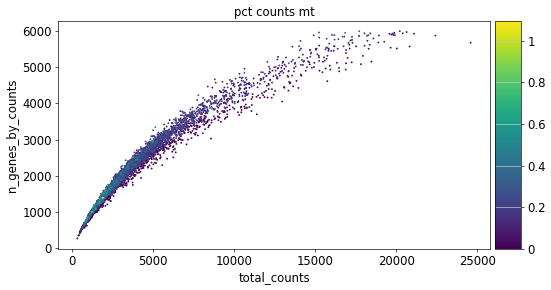

In [13]:
p1 = sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes_by_counts']<6000, adata.obs['total_counts']<40000)], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt', size=20,show=False)
p1.grid()
plt.show()

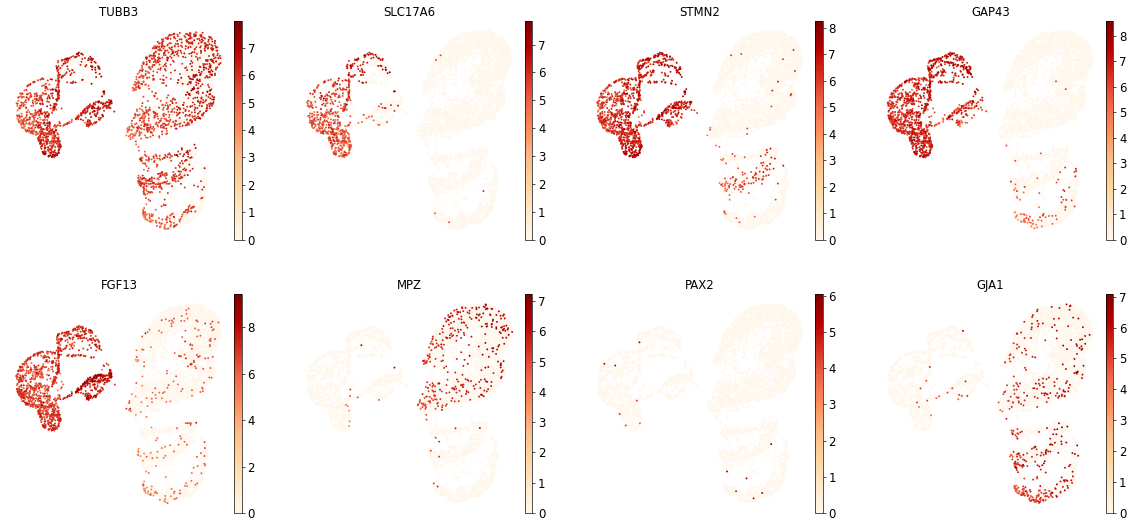

In [14]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_pp, color = ['TUBB3','SLC17A6','STMN2','GAP43', 'FGF13', 'MPZ', 'PAX2', 'GJA1'], frameon = False, color_map='OrRd', ncols=4)

# (1) Basic filtering

# Total counts

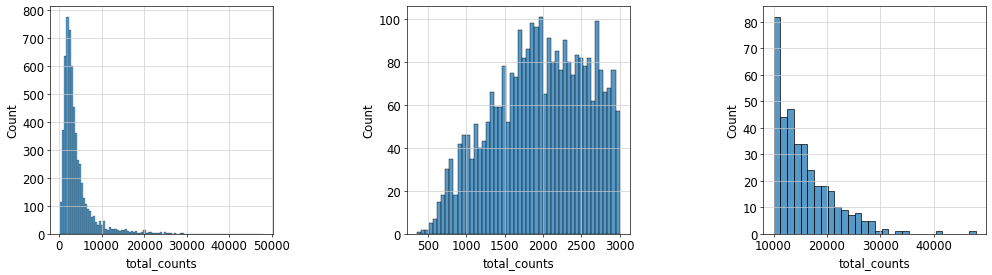

In [15]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sns.histplot(adata.obs['total_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=100)
#p3.set_xscale('log')
p4 = sns.histplot(adata.obs['total_counts'][adata.obs['total_counts']<3000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_xscale('log')
p5 = sns.histplot(adata.obs['total_counts'][adata.obs['total_counts']>10000], 
                 kde=False, bins=30, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

# n_genes_by_counts

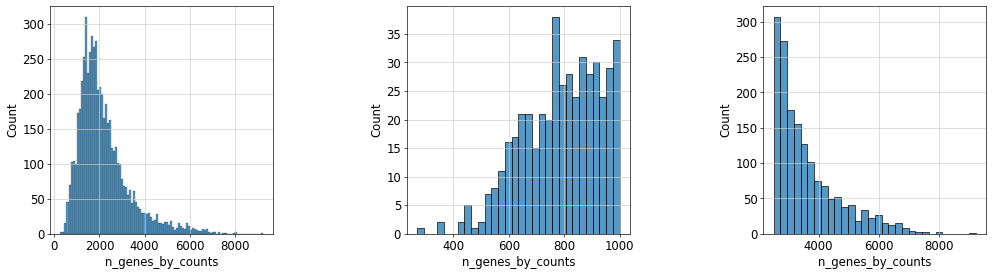

In [16]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sns.histplot(adata.obs['n_genes_by_counts'], kde=False, bins=100, ax=fig.add_subplot(fig_ind[0]))

p7 = sns.histplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p8 = sns.histplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']>2500], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

# pct_counts_mt

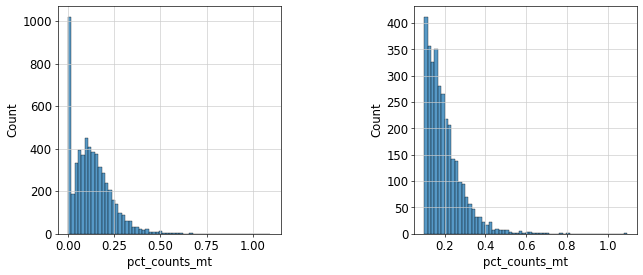

In [17]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sns.histplot(adata.obs['pct_counts_mt'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sns.histplot(adata.obs['pct_counts_mt'][adata.obs['pct_counts_mt'].between(0.1, 6)], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

# For cells that have too low/high metrics show on UMAP

In [18]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories])#, inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

total_counts_filter
ok     5551
low     224
Name: count, dtype: int64


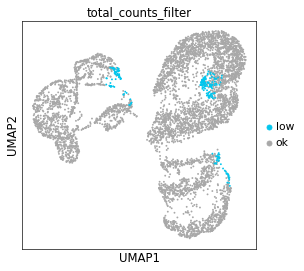

In [19]:
param='total_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=1000
COUNTS_THR_MAX=50000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

n_genes_by_counts_filter
ok      5310
low      462
high       3
Name: count, dtype: int64


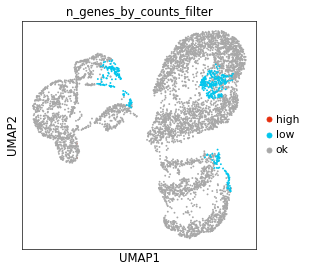

In [20]:
param='n_genes_by_counts'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=1000
GENES_THR_MAX=8000
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

pct_counts_mt_filter
ok    5775
Name: count, dtype: int64


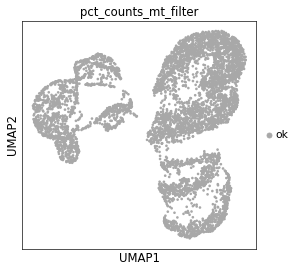

In [21]:
param='pct_counts_mt'
MT_THR=3
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

# N cells in which a gene is expressed:

In [22]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

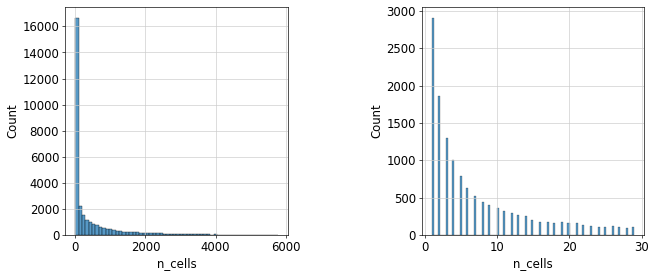

<Axes: xlabel='n_cells'>

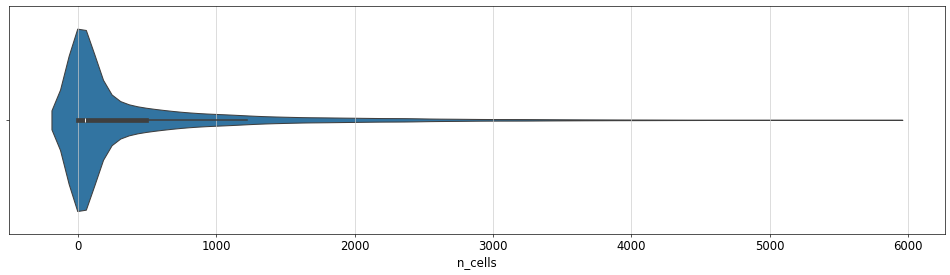

In [23]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sns.histplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sns.histplot(adata.var['n_cells'][adata.var['n_cells']<30], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sns.violinplot(x=adata.var['n_cells'])


# Filter out genes and cells according to threshold

In [24]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = GENES_THR_MAX)
print('Number of cells after max gene filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts = COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 5775
filtered out 462 cells that have less than 1000 genes expressed
Number of cells after gene filter: 5313
filtered out 3 cells that have more than 8000 genes expressed
Number of cells after max gene filter: 5310
Number of cells after min count filter: 5310
Number of cells after max count filter: 5310
Number of cells after MT filter: 5310


# Doublet Removal - Scrublet

In [25]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

VSN_E3_spheroid_fresh_day32 N cells: 5310
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.8%
Elapsed time: 14.5 seconds


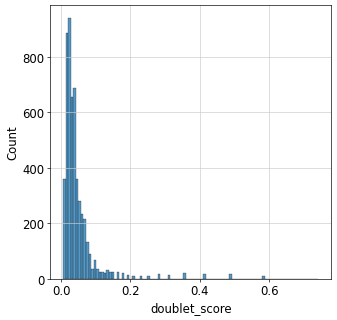

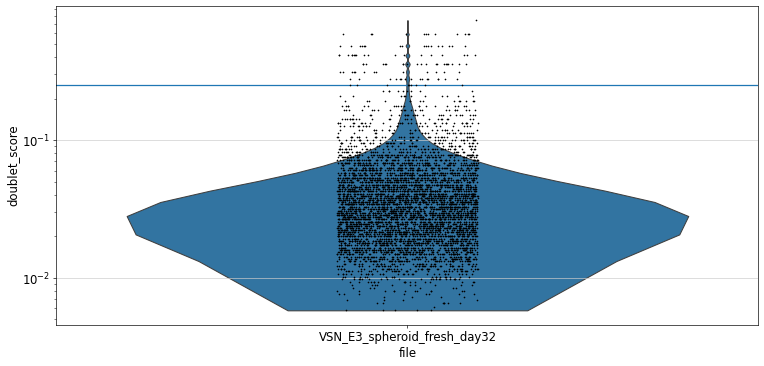

In [26]:
rcParams['figure.figsize']=(6,6)
sns.histplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.25
ax.axhline(DOUBLET_THR)
plt.show()

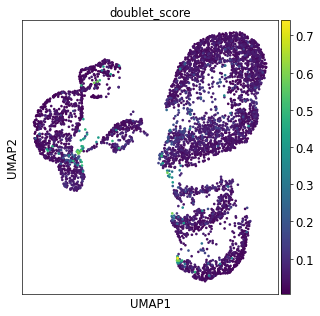

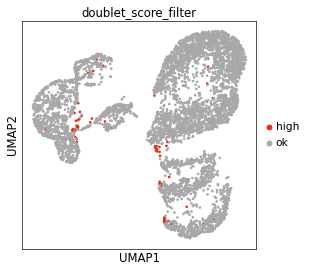

Doublet assignment: doublet_score_filter
ok      5203
high     107
Name: count, dtype: int64


In [27]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]
# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index,:], color=[param+'_filter'],size=40)
print('Doublet assignment:',adata.obs[param+'_filter'].value_counts())

In [28]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 5310
Number of cells after doublet filter: 5203


# QC Summary

In [29]:
# Summary statistics per file/batch
df = adata.obs[['n_genes_by_counts','total_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes_by_counts'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes_by_counts'].median()
df_all['mean_counts']=df.groupby(by='file')['total_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['total_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
VSN_E3_spheroid_fresh_day32,2271.8,1972.0,4287.8,3075.0,5203.0


# Save QC data

In [30]:
bdata = anndata_from_h5(file='cellbender_VSN_E3_spheroid_fresh_filtered.h5')
bdata.var_names_make_unique()
bdata

Assuming we are loading a "filtered" file that contains only cells.


AnnData object with n_obs × n_vars = 5779 × 38606
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale'
    var: 'ambient_expression', 'feature_type', 'gene_id'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [31]:
##add column
bdata.obs['file']='VSN_E3_spheroid_fresh_day32'

In [32]:
adata.obs['barcodes'] = adata.obs.index
identifyD = dict(zip(adata.obs.index, adata.obs.doublet))
bdata.obs['doublet'] = bdata.obs.index.map(identifyD)

cdata = bdata[bdata.obs['doublet'].isin([False])].copy()
cdata.obs['doublet'] = 'singlet'
cdata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,file,doublet
barcode,,,,,
ATGTCCCGTATCCTTT-1,4.843632,0.999993,6460.095215,VSN_E3_spheroid_fresh_day32,singlet
CATCCACTCCTACTGC-1,4.581496,0.999983,5669.772461,VSN_E3_spheroid_fresh_day32,singlet
CCATAAGCATCCGGCA-1,4.380176,0.999975,5507.041992,VSN_E3_spheroid_fresh_day32,singlet
GCTTCACCACGGTGCT-1,4.258233,0.999977,5500.690918,VSN_E3_spheroid_fresh_day32,singlet
AGCTCAACACGCACCA-1,4.242109,0.999974,5243.242676,VSN_E3_spheroid_fresh_day32,singlet
...,...,...,...,...,...
CGAAGGATCTATGTGG-1,0.584633,0.998785,2798.631348,VSN_E3_spheroid_fresh_day32,singlet
CTGTGGGGTGAAGCGT-1,0.536197,0.998861,2767.990967,VSN_E3_spheroid_fresh_day32,singlet
CTGTGAAAGATACGAT-1,0.559742,0.998996,2765.108643,VSN_E3_spheroid_fresh_day32,singlet


In [33]:
#cdata.write_h5ad("VSN_E3_fresh_spheroid_day32_cellranger8_CellBender_scrublet_QC.h5ad")